In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error

### Our data
<b>The data contains some Latin characters since columns are represented in both French and English. An encoding is needed in this case.</b>

In [97]:
data = pd.read_csv(
    'data/cfia-acia-1211-childrens-food-project.csv', encoding = "ISO-8859-1")
data.head()


,Sample No.  No. déchantillon,Region - Région,Commodity,denrée,Function,Fonction,Origin,Origine,Product,Produit,Date Sampled  Date déchantillonage,Component,Composant,AMOUNT,Report Unit - Unité de rapport
0,CFP2019-0001,ONTARIO,IMFD,DAIM,Domestic,domestique,CANADA,CANADA,Yogurt,Yogourt,15-Aug-19,Diquat,diquat,0.0,µg/g
1,CFP2019-0001,ONTARIO,IMFD,DAIM,Domestic,domestique,CANADA,CANADA,Yogurt,Yogourt,15-Aug-19,Paraquat,paraquat,0.0,µg/g
2,CFP2019-0001,ONTARIO,IMFD,DAIM,Domestic,domestique,CANADA,CANADA,Yogurt,Yogourt,15-Aug-19,AminomethylPhosphonic Acid,Acide (aminométhyl) phosphonique,0.0,µg/g
3,CFP2019-0001,ONTARIO,IMFD,DAIM,Domestic,domestique,CANADA,CANADA,Yogurt,Yogourt,15-Aug-19,Glyphosate,glyphosate,0.0,µg/g
4,CFP2019-0001,ONTARIO,IMFD,DAIM,Domestic,domestique,CANADA,CANADA,Yogurt,Yogourt,15-Aug-19,Aluminum,Aluminium,0.0,µg/g


<b> Columns in French and unneeded columns can be dropped. Some renaming is also needed.</b>

In [65]:
cols = ['Region - Région', 'Function', 'Origin', 'Product', 'Component', 'AMOUNT']
children_food = data[cols].rename(columns={data.columns[1]: 'Region'})
children_food.head()


,Region,Function,Origin,Product,Component,AMOUNT
0,ONTARIO,Domestic,CANADA,Yogurt,Diquat,0.0
1,ONTARIO,Domestic,CANADA,Yogurt,Paraquat,0.0
2,ONTARIO,Domestic,CANADA,Yogurt,AminomethylPhosphonic Acid,0.0
3,ONTARIO,Domestic,CANADA,Yogurt,Glyphosate,0.0
4,ONTARIO,Domestic,CANADA,Yogurt,Aluminum,0.0


In [66]:
children_food.Function.unique()

array(['Domestic', 'Unknown', 'Import'], dtype=object)

Region: where the product was both Ontario or Quebec
Function: 'Domestic', 'Unknown', 'Import'
Origin: country of origine of the product 

In [67]:
#children_food.Origin.value_counts()

In [85]:
children_food['Has_chemicals'] = np.where(children_food.AMOUNT == 0, 0, 1)
children_food.head()

,Region,Function,Origin,Product,Component,AMOUNT,Has_chemicals
0,ONTARIO,Domestic,CANADA,Yogurt,Diquat,0.0,0
1,ONTARIO,Domestic,CANADA,Yogurt,Paraquat,0.0,0
2,ONTARIO,Domestic,CANADA,Yogurt,AminomethylPhosphonic Acid,0.0,0
3,ONTARIO,Domestic,CANADA,Yogurt,Glyphosate,0.0,0
4,ONTARIO,Domestic,CANADA,Yogurt,Aluminum,0.0,0


In [69]:
#plt.hist(children_food.Has_chemicals)
#plt.show()

In [70]:
#food_check = children_food[['Origin', 'Product', 'Component', 'AMOUNT']]
#checker = children_food['Has_chemicals']

In [86]:
kids_food_X = children_food[['Origin', 'Product', 'Component', 'AMOUNT']]
kids_food_y = children_food['Has_chemicals']

In [87]:
X_train, X_val, y_train, y_val = train_test_split(
    kids_food_X, kids_food_y, random_state = 0)
#X_train.head()

Given that we are dealing with categorical data, we have to encode the training and test data.

In [88]:
encoder = preprocessing.LabelEncoder()
X_train_encoded = X_train.apply(encoder.fit_transform)
X_val_encoded = X_val.apply(encoder.fit_transform)
#X_train_encoded.head()
X_val_encoded.head()

,Origin,Product,Component,AMOUNT
112893,16,3,484,0
64395,1,2,212,0
103566,15,3,90,0
126923,15,4,217,0
63536,1,2,409,0


In [91]:
model1 = DecisionTreeRegressor()
model1.fit(X_train_encoded, y_train)
prediction = model1.predict(X_val_encoded)

print(mean_absolute_error(y_val, prediction))

0.0


In [94]:
from sklearn.ensemble import RandomForestRegressor

model2 = RandomForestRegressor(random_state=1)
model2.fit(X_train_encoded, y_train)
prediction2 = model2.predict(X_val_encoded)

print(mean_absolute_error(y_val, prediction2))

3.0834853662923656e-06


In [104]:
output = pd.DataFrame({'Origin': X_val.Origin, 
                       'Has_chemicals': prediction2}).reset_index(drop=True)
output.head()


,Origin,Has_chemicals
0,UNKNOWN,0.0
1,CANADA,0.0
2,UNITED STATES,0.0
3,UNITED STATES,0.0
4,CANADA,0.0


#### Origin of products with highers number of chemicals 

<AxesSubplot:ylabel='Origin'>

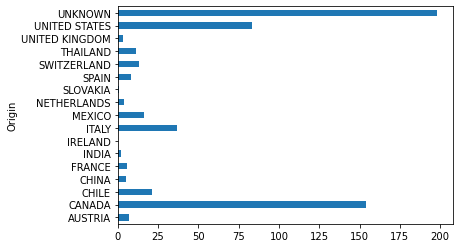

In [122]:
# Country with the highest number of products with chemicals
output.groupby('Origin')['Has_chemicals'].sum().plot(kind='barh')


This needs to be compare to the amount
of product tested originating from that country

<AxesSubplot:>

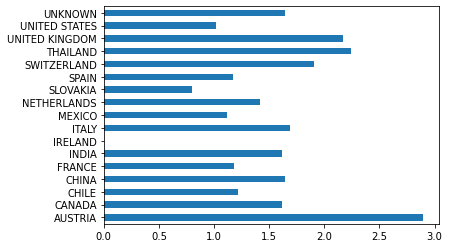

In [123]:
a = 100*output.groupby('Origin')['Has_chemicals'].sum()/(
    output.Origin.value_counts())
a.plot(kind='barh')

In [125]:
# The total percentage can also be measured
output.groupby('Origin').agg({"Has_chemicals" : "sum"}
                            ).apply(lambda x: 100*x/x.sum())

,Has_chemicals
Origin,
AUSTRIA,1.230488
CANADA,27.070735
CHILE,3.691464
CHINA,0.878920
FRANCE,1.054704
INDIA,0.351568
IRELAND,0.000000
ITALY,6.504008
MEXICO,2.812544
